In [31]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import fsolve
from scipy.signal import find_peaks
from sklearn.metrics import r2_score as r2

years = [1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965]
rice_production = [-39.69, -7.51, -44.61, 0, -32.53, -43.36, -59.23, -76.33, -85.63, -23.83, -30.49, -29.0]
positive_rice_production = [(val - min(rice_production)) / (max(rice_production) - min(rice_production)) for val in rice_production]

def system(t, y, Eh, *params):
  S, L, G = y

  a1, a2, b1, b5, c1, c2, c3 = params

  #Sparrows live 3 years on average
  a3 = 1/3

  #Locusts die and lay new eggs every year
  b4 = 1

  #Locusts multiply about 15% faster while gregarious
  b2 = 0.15 * b1

  #To make the locusts swarms turn on quickly
  b3 = 0.01

  c3 = 1



  def f(L):
    return b1 + (b2 * L**2) / (b3**2 + L**2)

  dS = (a1 * S * L) + (a2 * G * S) - (a3 * S) - (Eh * S)
  dL = f(L) * L - (b4 * L) - (b5 * S * L)
  dG = 1 - (c1 * G * S) - (c2 * G * L) - (c3 * G)

  return [dS, dL, dG]

#         a1,    a2,   b1,   b5,    c1,    c2,    c3
params = [0.001, 0.00, 1.50, 0.005, 0.001, 0.005, 0.05]





numYears = 30
stepsPerYear = 30
t_span = (0, numYears)
t_eval = np.linspace(0, numYears, stepsPerYear * numYears)


def run_simulation(S0, L0, G0, Eh=0.0, graphSL = False, graphGrains = False, useChicago = True, getPeriod = False):
  """Simulate and optionally plot the system for given hunting/farming efforts."""
  y0 = [S0, L0, G0]
  #Find solution without hunting to help nondimensionalize Chicago grain
  huntingFree = solve_ivp(system, t_span, y0, t_eval=t_eval, args=(0, *params))
  maxHuntingFreeGrain = max(huntingFree.y[2])

  #Scaled Chicago Data between 0 and 1
  positive_rice_production = [(val - min(rice_production)) / (max(rice_production) - min(rice_production))for val in rice_production]

  #Now scale to have the max of Chicago data match the max of the hunting free grain production
  positive_rice_production = [val * maxHuntingFreeGrain for val in positive_rice_production]
  #Now find with hunting effort
  sol = solve_ivp(system, t_span, y0, t_eval=t_eval, args=(Eh, *params))


  #Graphing Sparrow and Locust Popolations
  if graphSL:
    plt.figure(figsize=(8,5))
    plt.plot(sol.t, sol.y[0], label=f'Sparrows')
    plt.plot(sol.t, sol.y[1], label=f'Locusts')
    plt.xlabel('Time (years)')
    plt.ylabel('Individuals / Index')
    plt.title(f'Simulation: Eh={Eh}')
    plt.legend()
    plt.grid(True)
    plt.show()

  #Graphing Grain vs Chicago Data
  if graphGrains:
    plt.figure(figsize=(8,5))
    if useChicago:
      plt.plot(list(range(12)), positive_rice_production, label=f'Chicago Rice Data')
    plt.plot(sol.t, sol.y[2], label=f'Grain')
    plt.title(f'Simulation: Eh={Eh}')
    plt.legend()
    plt.grid(True)
    plt.show()


  #Now get period of cycles if wanted
  #Use locust pop for best math.isclose behavior
  if getPeriod:
    locusts = sol.y[1]
    peaks = find_peaks(locusts)[0]
    peakDists = [peaks[i] - peaks[i-1] for i in range(1, len(peaks))]
    avgPeakDist = sum(peakDists) / len(peakDists)
    print(f'Period of length {avgPeakDist / stepsPerYear}')

  #Now getting fit quality
  simGrains = sol.y[2]

  epsilon = 10**-6
  grainsForFit = []
  for i in range(12 * stepsPerYear):
    if i % stepsPerYear == 0:
      grainsForFit.append(simGrains[i])

  fit = r2(positive_rice_production, grainsForFit)
  return fit

In [28]:
"""
A couple nice functions that report steady states and their equilibrium.
"""
def report_steady_state(S: float, L: float, G: float):
    print(f"Sparrow population: {S:.3f}")
    print(f"Locust population: {L:.3f}")
    print(f"Grain: {G:.3f}")

def report_equilibrium(*eigenvalues: float):
    """
    Prints eigenvalues and classifies stability.

    TODO: Due to floating point, an == 0 check is unlikely. We may consider
    having some small value epsilon, and use this to check if things are zero.
    """
    for i, lam in enumerate(eigenvalues, start=1):
        print(f"λ_{i} = {lam}")

    # Use real parts when deciding stability
    eps = 1e-12
    reals = [lam.real for lam in eigenvalues]

    has_pos = any(r > eps for r in reals)
    has_neg = any(r < -eps for r in reals)
    has_zero = any(abs(r) <= eps for r in reals)

    if has_zero:
        print("Classification: equilibrium with a zero eigenvalue (nonhyperbolic)")
    elif has_pos and has_neg:
        print("Classification: unstable saddle equilibrium")
    elif has_pos and not has_neg:
        print("Classification: unstable equilibrium")
    elif has_neg and not has_pos:
        print("Classification: stable equilibrium")
    else:
        print("Classification: unable to classify (unexpected case)")

In [34]:
import numpy as np
from scipy.stats import qmc
import warnings
# warnings.filterwarnings('error', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

def run_lhs_simulations(n_samples=10, param_bounds=None, expressive = False):
  #General approach of Latin hypercube sampling and sample inputs not original
  #Customized range, finding initial steady state before solving the equations
  #Also spent a lot of time dealing with weird behavior

  param_bounds = [
      (0.001, 0.01),   # a1
      (0.0, 0.1),      # a2
      (0.5, 2.5),       # b1
      (0.001, 0.01),    # b5
      (0.0001, 0.01),   # c1
      (0.001, 0.01),    # c2
      (0.01, 0.1),      # c3
      (0.0, 1.0)        #Eh
  ]

  # Create LHS sampler
  sampler = qmc.LatinHypercube(d=len(param_bounds))
  sample = sampler.random(n=n_samples)

  # Scale samples to parameter bounds
  l_bounds = [low for low, high in param_bounds]
  u_bounds = [high for low, high in param_bounds]
  scaled_samples = qmc.scale(sample, l_bounds, u_bounds)

  results = []


  def f(L: float) -> float:
      return b1 + (b2 * (L**2))/(b3**2 + L**2)

  def dfdx(L: float) -> float:
      return (2 * b2 * (b3**2) * L)/((b3**2 + L**2) ** 2)
  def coexistence_equation_scalar(L: float) -> float:
      """
      It is possible to solve for the values of S and G in terms of L.

      We build an equation whose root corresponds to the L at a steady state,
      so we can calculate S and G from that root.

      Deriving this function:

      dL/dt = 0 gets us to f(L) - b4 - b5 * S = 0, so S(L) = (f(L) - b4) / b5

      dG/dt = 0 gets us to G(L) = 1 / (c1 * S(L) + c2 * L + c3)

      dS/dt = 0 gets us to a1 * S * L + a2 * S * G - a3 * S - Eh * S = 0.
      Since S > 0, we can write this as a1 * L + a2 * G = a3 + Eh.

      > a1 * L + a2 * G = a3 + Eh <  is true at equilibrium.
      So then, we can set F(L) = a1*L + a2 / (c1*S(L) + c2*L + c3) - (a3 + Eh)
      and having this value equal to 0 gives us the L at equilibrium.

      We then use a root solver on F.
      """
      if L <= 0:
          return float("nan")

      S = (f(L) - b4) / b5
      if S < 0:
          return float("nan")

      denom = c1*S + c2*L + c3
      G = 1.0 / denom
      if G < 0:
          return float("nan")

      return a1*L + a2*G - (a3 + Eh)

  bestFit = 0.0
  bestParams = None
  bestEquilibrium = None
  for i, param_set in enumerate(scaled_samples):
    if expressive:
      print(f"\n--- Simulation {i+1} with params {param_set} ---")
    params = param_set
    a1, a2, b1, b5, c1, c2, c3, Eh = params

    #Sparrows live 3 years on average
    a3 = 1/3

    #Locusts die and lay new eggs every year
    b4 = 1

    #Locusts multiply about 15% faster while gregarious
    b2 = 0.15 * b1

    #To make the locusts swarms turn on quickly
    b3 = 0.01

    c3 = 1
    def find_coexistence_equilibrium_fsolve():
      """
      Shove our problems at scipy and win.
      """
      L0 = 1.0
      Eh = 0.0
      try:
        L_star = fsolve(coexistence_equation_scalar, L0)[0]

        if L_star <= 0 or not np.isfinite(L_star):
          if expressive:
            print("fsolve returned invalid L*")
          return None

        S_star = (f(L_star) - b4) / b5
        denom = c1*S_star + c2*L_star + c3
        G_star = 1.0 / denom

        if S_star < 0 or G_star < 0:
          if expressive:
            print("Invalid result for case D, coexistence. ")
          return None

        return S_star, L_star, G_star
      except RuntimeWarning:
        return None

    steadyState = find_coexistence_equilibrium_fsolve()
    if steadyState is None:
      if expressive:
        print("Steady state not found")
      continue
    S0, L0, G0 = steadyState
    fit = run_simulation(S0, L0, G0, Eh=Eh)
    if bestFit == None or fit > bestFit:
      bestFit = fit
      bestParams = params
      bestEquilibrium = steadyState
    if expressive:
      print(f"Fit: {fit}")

  return bestParams, bestFit, bestEquilibrium



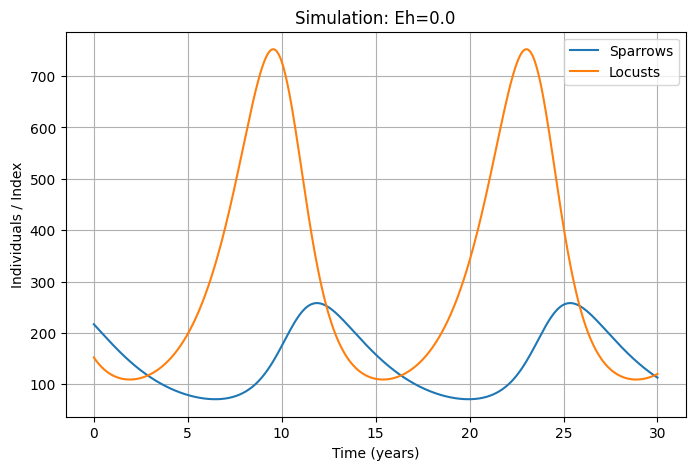

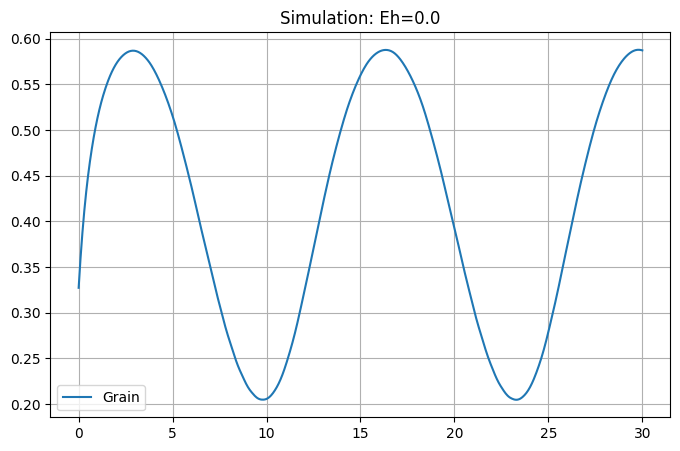

Period of length 13.466666666666667


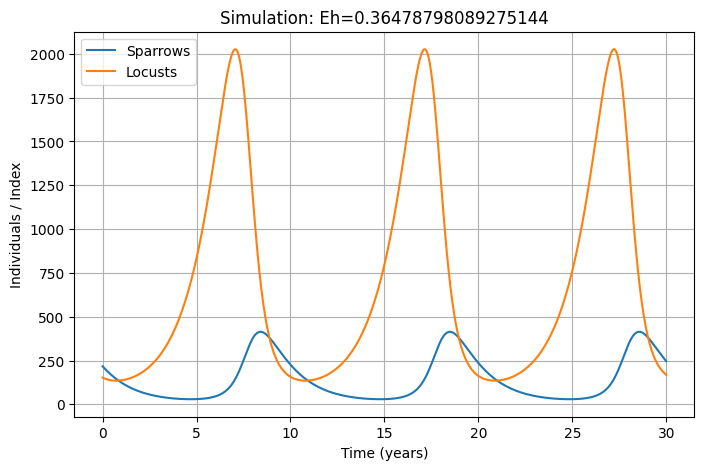

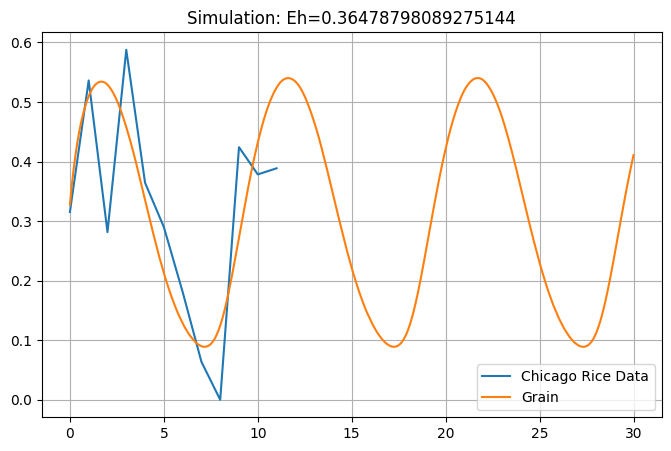

Period of length 10.066666666666666


0.5467566647872186

In [35]:
params = [0.001, 0.00, 1.50, 0.005, 0.001, 0.005, 0.05]
bestParams, fit, equilibrium = run_lhs_simulations(n_samples = 1000)
S0, L0, G0 = equilibrium
Eh = bestParams[-1]
run_simulation(S0, L0, G0, Eh=0.0, graphSL=True, graphGrains=True, useChicago = False, getPeriod = True)
run_simulation(S0, L0, G0, Eh=Eh, graphSL=True, graphGrains=True, useChicago = True, getPeriod = True)
